### CNN 프로젝트

#### 주제

- 바다 동물 이미지 다중 분류

#### 데이터 수집 링크

- kaggle: https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste


#### 목차

1. 데이터(이미지) 탐색
2. 학습/검증/테스트 데이터(이미지) 분리 및 파일 처리
3. 사전 훈련 모델로 분류 예측
   1) VGG16
   2) Xception
   3) ResNet50
   4) MobileNetV2
4. Xception 모델 학습 진행
5. 미세 조정(fine-tuning) 진행
6. 요약 및 느낀점

#### 1. 데이터(이미지) 탐색

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/sea_animals/original/'

idg = ImageDataGenerator(rescale=1./255)
generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=True)

print(generator.class_indices)

Found 13711 images belonging to 23 classes.
{'Clams': 0, 'Corals': 1, 'Crabs': 2, 'Dolphin': 3, 'Eel': 4, 'Fish': 5, 'Jelly Fish': 6, 'Lobster': 7, 'Nudibranchs': 8, 'Octopus': 9, 'Otter': 10, 'Penguin': 11, 'Puffers': 12, 'Sea Rays': 13, 'Sea Urchins': 14, 'Seahorse': 15, 'Seal': 16, 'Sharks': 17, 'Shrimp': 18, 'Squid': 19, 'Starfish': 20, 'Turtle_Tortoise': 21, 'Whale': 22}


- 총 23개 종류의 타겟을 가진 약 13,711개의 이미지로 구성되어 있음을 알 수 있습니다.
- 무작위로 이미지 1개를 선정하여 실제로 어떻게 구성되어 있는지 확인해봅니다.

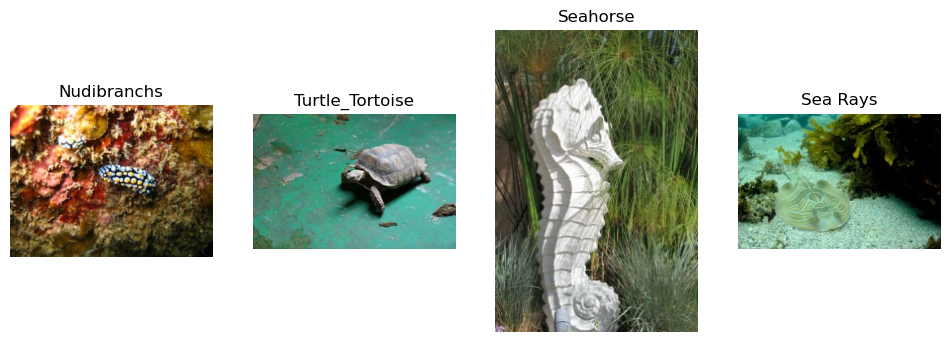

In [2]:
import cv2
import matplotlib.pyplot as plt
import random

def show_image(ax, image, label):
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')

def get_random_images(generator, nrows=1, ncols=4):
    max_idx = generator.classes.__len__() - 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, 6))
    axs = axs.flatten()
    for i in range(nrows * ncols):
        random_idx = random.randint(0, max_idx)
        image = cv2.cvtColor(cv2.imread(generator.filepaths[random_idx]), cv2.COLOR_BGR2RGB)
        label = [k for k, v in generator.class_indices.items() if v == generator.classes[random_idx]][0]
        show_image(axs[i], image, label)
    plt.show()

get_random_images(generator)

#### 2. 학습/검증/테스트 데이터(이미지) 분리 및 파일 처리
- 이미지 데이터를 분리하기 위해 각 파일의 경로와 타겟을 데이터프레임으로 만들어줍니다.

In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'Clams',
 1: 'Corals',
 2: 'Crabs',
 3: 'Dolphin',
 4: 'Eel',
 5: 'Fish',
 6: 'Jelly Fish',
 7: 'Lobster',
 8: 'Nudibranchs',
 9: 'Octopus',
 10: 'Otter',
 11: 'Penguin',
 12: 'Puffers',
 13: 'Sea Rays',
 14: 'Sea Urchins',
 15: 'Seahorse',
 16: 'Seal',
 17: 'Sharks',
 18: 'Shrimp',
 19: 'Squid',
 20: 'Starfish',
 21: 'Turtle_Tortoise',
 22: 'Whale'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])
print(target_names.__len__())

13711


In [4]:
import pandas as pd

original_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
original_df.loc[:, 'file_paths'] = original_df.file_paths.apply(lambda x: x.replace('\\', '/'))

display(original_df)

,file_paths,target_names,targets
0,./datasets/sea_animals/original/Clams/10004815...,Clams,0
1,./datasets/sea_animals/original/Clams/10057431...,Clams,0
2,./datasets/sea_animals/original/Clams/10057493...,Clams,0
3,./datasets/sea_animals/original/Clams/10057511...,Clams,0
4,./datasets/sea_animals/original/Clams/10057638...,Clams,0
...,...,...,...
13706,./datasets/sea_animals/original/Whale/Whale (8...,Whale,22
13707,./datasets/sea_animals/original/Whale/Whale (8...,Whale,22
13708,./datasets/sea_animals/original/Whale/Whale (8...,Whale,22
13709,./datasets/sea_animals/original/Whale/Whale (8...,Whale,22


- 데이터프레임으로부터 `sklearn`의 `train_test_split()`을 사용하여 학습/검증/테스트 데이터를 분리합니다.

In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(original_df.file_paths, original_df.targets, stratify=original_df.targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
21    1522
6      676
3      625
17     472
14     463
22     458
9      450
12     425
13     414
8      400
10     400
1      400
20     399
7      399
2      399
4      398
0      398
5      395
18     390
11     386
19     386
15     382
16     331
Name: count, dtype: int64
targets
21    381
6     169
3     157
17    118
14    116
22    114
9     112
12    106
13    103
20    100
1     100
7     100
8     100
2     100
10    100
5      99
4      99
0      99
18     98
19     97
11     96
15     96
16     83
Name: count, dtype: int64


In [6]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
21    1218
6      541
3      500
17     378
14     370
22     366
9      360
12     340
13     331
1      320
10     320
8      320
2      319
20     319
7      319
4      318
0      318
5      316
18     312
11     309
19     309
15     306
16     265
Name: count, dtype: int64
targets
21    304
6     135
3     125
17     94
14     93
22     92
9      90
12     85
13     83
7      80
8      80
20     80
10     80
1      80
0      80
2      80
4      80
5      79
18     78
11     77
19     77
15     76
16     66
Name: count, dtype: int64


- 분리한 데이터들을 각각 원본 데이터프레임으로부터 인덱스로 추출하여 별도의 데이터프레임으로 분리합니다.

In [7]:
train_df = original_df.iloc[train_images.index].reset_index(drop=True)
validation_df = original_df.iloc[validation_images.index].reset_index(drop=True)
test_df = original_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(8774, 3)
(2194, 3)
(2743, 3)


- 실제 이미지 파일들을 학습/검증/테스트 데이터로 분리한 바에 맞게 폴더를 나누어 복사해줍니다.

In [16]:
import shutil
import os

root = './datasets/sea_animals/'

for file_path in train_images:
    sea_animal_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + sea_animal_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)
    
for file_path in validation_images:
    sea_animal_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + sea_animal_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

for file_path in test_images:
    sea_animal_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'test/' + sea_animal_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

#### 3. 사전 훈련 모델로 분류 예측
- `VGG16`, `Xception`, `ResNet50V2`, `MobileNetV2` 모델을 사용하여 예측을 수행합니다.
- 모델을 사용할 때 가중치를 `Imagenet` 데이터로 학습한 가중치로 불러온 후 결과를 확인함으로써,  
  바다 동물 데이터가 `Imagenet` 데이터와 유사도가 높은지 여부를 확인해봅니다.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2, Xception, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

IMAGE_SIZE = 224
BATCH_SIZE = 64

def path_to_input(img_path, preprocess_function, image_size=IMAGE_SIZE):
    img = image.load_img(img_path, target_size=(image_size, image_size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_function(img)

vgg = VGG16(weights='imagenet')
xcep = Xception(weights='imagenet')
res = ResNet50V2(weights='imagenet')
mob = MobileNetV2(weights='imagenet')

In [10]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import decode_predictions as vgg_decode_predictions
from tensorflow.keras.applications.xception import decode_predictions as xception_decode_predictions
from tensorflow.keras.applications.resnet_v2 import decode_predictions as resnet_decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions as mobilenet_decode_predictions

def show_random_image_with_prediction(model, model_name='vgg16'):
    image_size = IMAGE_SIZE
    if model_name == 'vgg16':
        preprocess_function = vgg_preprocess_input
        decode = vgg_decode_predictions
        
    elif model_name == 'xception':
        preprocess_function = xception_preprocess_input
        decode = xception_decode_predictions
        image_size = 299
        
    elif model_name == 'resnet50v2':
        preprocess_function = resnet_preprocess_input
        decode = resnet_decode_predictions
        
    elif model_name == 'mobilenetv2':
        preprocess_function = mobilenet_preprocess_input
        decode = mobilenet_decode_predictions
        
    else:
        return
    
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()
    
    for i in range(8):
        random_idx = random.randint(0, original_df.shape[0]-1)
        img_path = generator.filepaths[random_idx]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        label = [k for k, v in generator.class_indices.items() if v == generator.classes[random_idx]][0]
        input_tensor = path_to_input(img_path, preprocess_function, image_size=image_size)
        predictions = model.predict(input_tensor)
        decoded_predictions = decode(predictions, top=3)[0][0][1]
        show_image(axs[i], image, label)
        print(decoded_predictions)
    plt.show()

- 먼저 VGG16 모델로 랜덤한 8개 이미지에 대한 예측(`predict()`)을 수행하여 실제 정답과 비교해봅니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
jellyfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
seashore
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
coral_reef
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
eel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
jellyfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
puffer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
tiger_shark
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
jellyfish


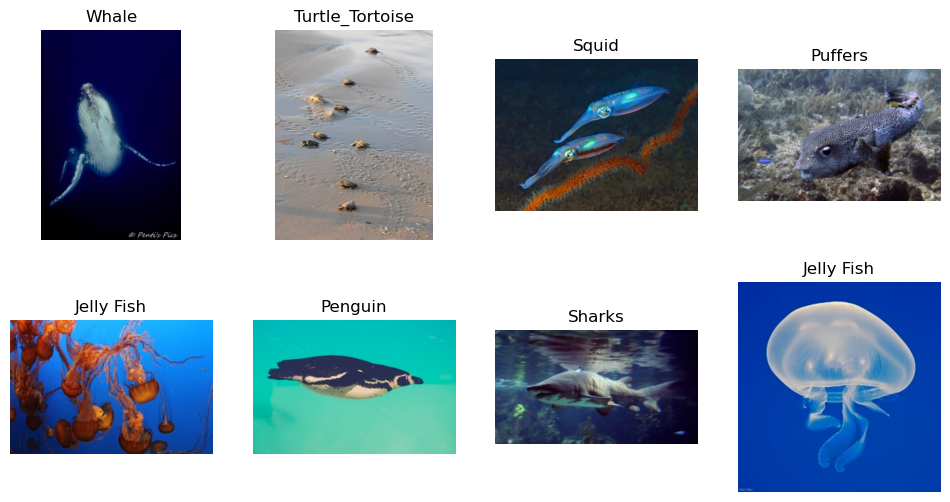

In [29]:
show_random_image_with_prediction(vgg)

- 두 번째는 `Xception` 모델을 사용하여 예측합니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
eel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
starfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
jellyfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
starfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
tiger_shark
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
sea_cucumber
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
starfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
terrapin


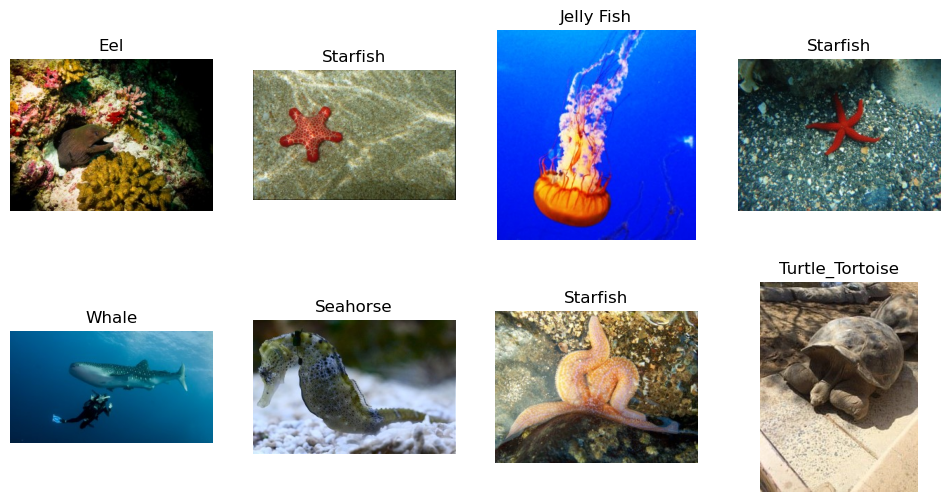

In [34]:
show_random_image_with_prediction(xcep, model_name='xception')

- 세 번째는 `ResNet50V2` 모델입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
honeycomb
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
tiger_shark
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
coral_fungus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
leatherback_turtle
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
tiger_shark
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
sea_slug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
rock_beauty


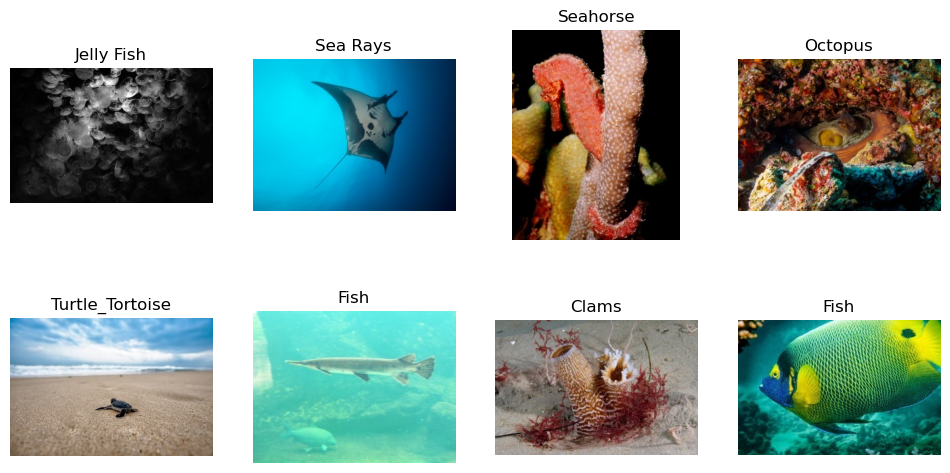

In [35]:
show_random_image_with_prediction(res, model_name='resnet50v2')

- 마지막으로 `MobileNetV2` 모델입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
hammerhead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
rock_beauty
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
sea_slug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
coral_reef
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
jellyfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
frilled_lizard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
sea_slug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
loggerhead


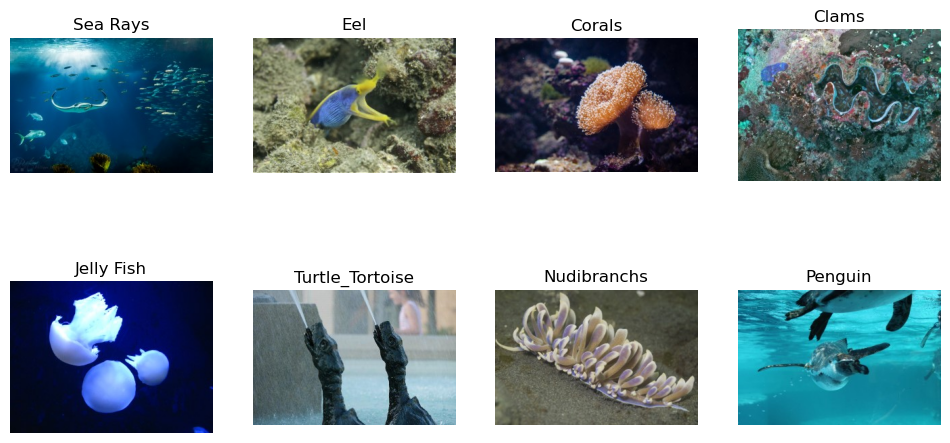

In [36]:
show_random_image_with_prediction(mob, model_name='mobilenetv2')

- **랜덤하게 고른 8장의 이미지에 대한 `predict()` 결과, 4가지 사전훈련모델 모두 대체로 어느 정도 준수한 예측 성능을 보였습니다.**
- 이는 각 사전훈련모델이 학습한 `imagenet` 데이터셋과, 현재 학습 대상 데이터셋인 바다 동물 **데이터셋의 유사도가  
  어느 정도 존재함**을 시사한다고 볼 수 있습니다.
- 특히 `Xception` 모델의 경우 랜덤하게 고른 8개의 이미지 중 6개를 정확히 맞췄으므로,  
  `Xception` 모델을 사용하여 직접 바다 동물 데이터를 학습시켜보고자 합니다.

#### 4. Xception 모델 학습 진행

- `Xception` 모델의 `Convolution Backbone` 층을 가져온 후, 직접 `Classifier Layer`를 재정의하여 `fit()`을 통해 학습을 진행합니다.
- 먼저 `keras` 라이브러리의 `Sequence` 클래스를 상속 받는 `Dataset` 클래스를 만들어 이후 훈련에 활용하고자 합니다.
- 해당 클래스를 만드는 목적은 `__len__()`, `__getitem__()`, `on_epoch_end()`등의 메소드를 재정의함으로써,  
  이미지를 불러올 때 `augmentation`을 적용하거나 스케일링 관련 `preprocess function`을 적용하기 위함입니다.

In [8]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 224
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)

            results_batch[i] = image

        return results_batch, targets_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)
            

- 다음은 `create_model()` 함수를 정의합니다.
- 해당 함수의 목적은 전달 받은 사전 훈련 모델의 종류에 따라 `Convolution Backbone` 층을 알맞게 사용하고,  
  이후 훈련할 데이터의 타겟에 맞게 분류기(`Classifier Layer`)를 재정의하여 `concatenate`하기 위함입니다.

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': 
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(100, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(23, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    else:
        pass

    return model

- 학습/검증/테스트 데이터의 파일 경로와 타겟 데이터를 통해 `Dataset`객체를 생성합니다.

In [10]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)

- `Xception` 사전훈련모델을 활용한 `model`객체를 생성합니다.

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 111, 111, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 111, 111, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 111, 111, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 109, 109, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 109, 109, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 109, 109, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 109, 109, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 109, 109, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 109, 109, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 55, 55, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 55, 55, 128)       │               

 Total params: 21,068,703 (80.37 MB)

 Trainable params: 21,014,175 (80.16 MB)

 Non-trainable params: 54,528 (213.00 KB)

- 콜백을 정의합니다.
- `ModelCheckpoint`를 통해 `epoch`마다 가중치를 파일로 내보내 저장합니다.
- `ReduceLROnPlateau`를 통해 `val_loss`의 변화에 따라 학습률을 동적으로 조정합니다.
- `EarlyStopping`을 통해 `val_loss`가 일정 `epoch` 반복 동안 감소하지 않을 경우 학습을 조기 종료합니다.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/sea_animals/xception/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

- `gc`를 통해 메모리를 최적화한 후, `fit()`을 통해 훈련을 진행합니다.

In [16]:
import gc

gc.collect()

729

In [17]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 1575s 11s/step - acc: 0.4693 - loss: 1.9276 - val_acc: 0.5934 - val_loss: 1.6295 - learning_rate: 0.0010
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1559s 11s/step - acc: 0.7662 - loss: 0.8871 - val_acc: 0.6814 - val_loss: 1.2629 - learning_rate: 0.0010
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1582s 11s/step - acc: 0.8323 - loss: 0.6430 - val_acc: 0.6290 - val_loss: 1.6065 - learning_rate: 0.0010
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1455s 11s/step - acc: 0.8569 - loss: 0.5577 - val_acc: 0.6577 - val_loss: 1.2591 - learning_rate: 0.0010
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1363s 10s/step - acc: 0.8715 - loss: 0.5081 - val_acc: 0.7106 - val_loss: 1.1892 - learning_rate: 0.0010
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1376s 10s/step - acc: 0.9071 - loss: 0.3601 - val_acc: 0.6996 - val_loss: 1.4380 - learning_rate: 0.0010
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1367s 10s/step - acc: 0.9261 - loss: 0.3073 - val_acc: 0.6828 - val_loss: 1.5770 - learning_rate: 0.0

In [18]:
model.evaluate(test_dataset)

43/43 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - acc: 0.8239 - loss: 0.8479


[0.8945260643959045, 0.8162595629692078]

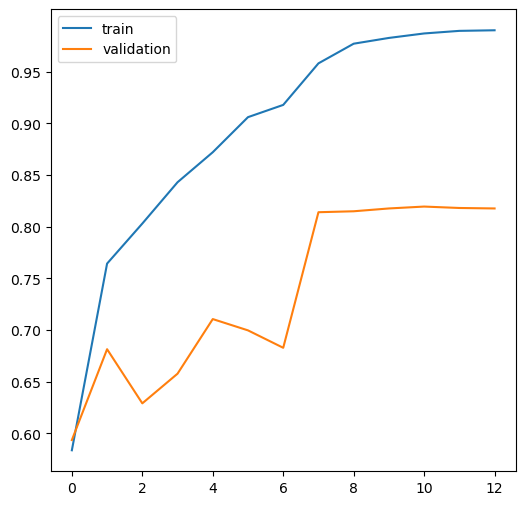

In [19]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 5. 미세 조정(fine-tuning) 진행

- 미세 조정을 적용하여 모델을 만들고 학습시키는 함수인 `fine_tune()`을 정의합니다.
- 먼저 분류기를 제외한 모든 `Convolution Layer`를 freeze 시킨 채로 `fit()`을 수행하여 10 Epoch 동안 학습합니다.
- 이후 `block 13`과 `block 14` layer를 활성화시킨 후 다시 10 Epoch 동안 학습하되, `Adam()` Optimizer의 학습률을 `1e-4`로 낮추어 진행합니다.
- 다음은 `block 11`과 `block 12` layer 또한 활성화하여 10 Epoch 동안 학습하되, 학습률을 `1e-5`로 조정합니다.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/sea_animals/xception/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers

IMAGE_SIZE = 224
BATCH_SIZE = 64

def fine_tune(datas, model_name, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    THIRD_EPOCHS = 10
    
    train_file_paths, train_targets, validation_file_paths, validation_targets, test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=preprocess, shuffle=True)
    validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=preprocess)

    model = create_model(model_name=model_name, verbose=True)

    # 1단계: 분류기(Classifier layers) 층을 제외한 layer들을 모두 freeze
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history1 = model.fit(train_dataset, 
                         batch_size=BATCH_SIZE, 
                         epochs=FIRST_EPOCHS, 
                         validation_data=validation_dataset,
                         callbacks=[mcp_cb, rlr_cb, ely_cb]
                        )

    # 2단계: block 13, 14 층 활성화
    for layer in model.layers[125:-5]:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-4), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history2 = model.fit(train_dataset, 
                         batch_size=BATCH_SIZE, 
                         epochs=SECOND_EPOCHS, 
                         validation_data=validation_dataset,
                         callbacks=[mcp_cb, rlr_cb, ely_cb]
                        )

    # 3단계: block 11, 12 층 활성화
    for layer in model.layers[105:125]:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history3 = model.fit(train_dataset, 
                         batch_size=BATCH_SIZE, 
                         epochs=THIRD_EPOCHS, 
                         validation_data=validation_dataset,
                         callbacks=[mcp_cb, rlr_cb, ely_cb]
                        )

    return model, history1, history2, history3

In [21]:
import gc

gc.collect()

482

In [22]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

model, history1, history2, history3 = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', xception_preprocess_input)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 111, 111, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 111, 111, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 111, 111, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 109, 109, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 109, 109, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 109, 109, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 109, 109, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 109, 109, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 109, 109, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 55, 55, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 55, 55, 128)       │               

 Total params: 21,068,703 (80.37 MB)

 Trainable params: 21,014,175 (80.16 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - acc: 0.4134 - loss: 2.0961 - val_acc: 0.7434 - val_loss: 0.8891 - learning_rate: 0.0010
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - acc: 0.6925 - loss: 1.0577 - val_acc: 0.7707 - val_loss: 0.7776 - learning_rate: 0.0010
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - acc: 0.7180 - loss: 0.9643 - val_acc: 0.7853 - val_loss: 0.7402 - learning_rate: 0.0010
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - acc: 0.7331 - loss: 0.8839 - val_acc: 0.7871 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - acc: 0.7450 - loss: 0.8536 - val_acc: 0.7931 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - acc: 0.7618 - loss: 0.7956 - val_acc: 0.7958 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 589s 4s/step - acc: 0.7612 - loss: 0.7817 - val_acc: 0.7917 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 8/10

In [23]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - acc: 0.8434 - loss: 0.5455


[0.5529797077178955, 0.8428727388381958]

- 3단계 (block 11, 12 층부터 활성화) 학습의 Epoch 5에서 `EarlyStopping` 되었습니다.
- 이때 학습 데이터와 검증 데이터, 테스트 데이터에 대한 정확도는 각각 약 0.9049, 0.8309, 0.8434로 매우 준수한 성능을 보였으며,  
  미세 조정을 진행하지 않았을 때 13번의 Epoch에 걸린 시간(약 18,000 초)보다 훨씬 적은 시간 안에 학습을 진행할 수 있었습니다.  
  실제로 미세 조정(`fine-tuning`)을 진행하였을 때 총 25번의 Epoch만큼 반복하는 데 약 15,000 초가 소요되었습니다.

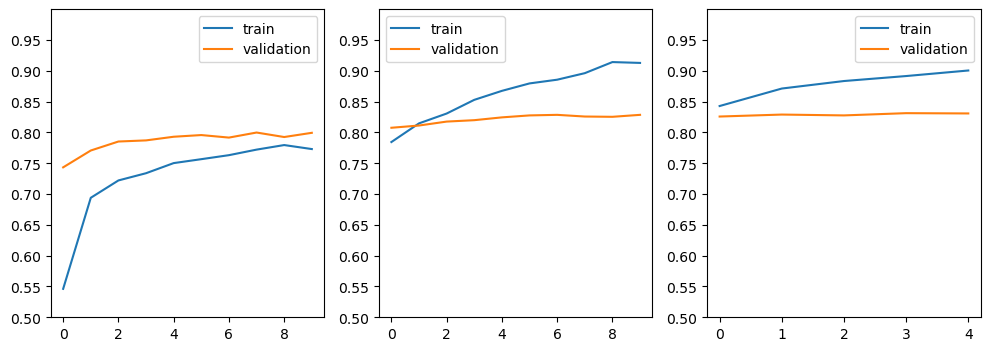

In [29]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].set_yticks(np.arange(0, 1, 0.05))
axs[0].set_ylim(0.5, 1)
axs[0].plot(history1.history['acc'], label='train')
axs[0].plot(history1.history['val_acc'], label='validation')
axs[0].legend()

axs[1].set_yticks(np.arange(0, 1, 0.05))
axs[1].set_ylim(0.5, 1)
axs[1].plot(history2.history['acc'], label='train')
axs[1].plot(history2.history['val_acc'], label='validation')
axs[1].legend()

axs[2].set_yticks(np.arange(0, 1, 0.05))
axs[2].set_ylim(0.5, 1)
axs[2].plot(history3.history['acc'], label='train')
axs[2].plot(history3.history['val_acc'], label='validation')
axs[2].legend()


plt.show()

#### 📌6. 요약 및 느낀점

- 새로운 이미지 데이터로 아무런 추가 작업 없이 `predict()`을 수행하였음에도 불구하고, 4개의 사전훈련모델 모두 어느 정도 준수한 예측 성능을 보였다는 점에서,  
  `imagenet` 등 사전훈련모델이 훈련 대상으로 선정했던 이미지 데이터와 유사한 데이터의 경우 추가적인 학습 없이도  
  어느 정도의 정확도를 이끌어낼 수 있다는 점이 놀라웠습니다.
- 이때 특히 높은 정확도를 보였다고 판단되는 사전훈련모델인 `Xception` 모델의 분류기(`Classifier Layer`) 층만을 재정의하여  
  해당 이미지 데이터로 학습을 진행하였을 때, 학습/검증/테스트 데이터에서의 정확도가 각각  
  **약 0.9899, 0.8177, 0.8239**로 매우 준수한 예측 성능을 보였지만 어느 정도 과적합의 위험이 있다고 판단하였습니다.
- 이후 미세 조정(`fine-tuning`)을 진행하여,  
  총 30번의 Epoch를 반복하며 10번마다 활성화 층의 종류와 학습률을 다르게 설정하였습니다.
- 이때 25번째 Epoch에서 `EarlyStopping`이 적용되었으며 학습/검증/테스트 데이터에서의 정확도가 각각  
  **약 0.9049, 0.8309, 0.8434**로, 미세 조정 없이 학습하였을 때보다 학습 데이터에서의 정확도는 다소 낮았지만,  
  검증 데이터와 테스트 데이터에서의 정확도가 비슷하게 나타났습니다.
- 게다가 미세 조정 없이 학습하였을 때 **13번의 Epoch를 반복하는 데 약 18,000초**가 소요되었지만,  
  미세 조정을 적용하였을 때 **25번의 Epoch를 반복하는 데 약 15,000초**가 소요되어 시간 복잡도 측면에서도 더 유리한 결과를 얻을 수 있었습니다.
- 따라서 적은 시간 안에 비슷한 성능을 보였다는 점에서 미세 조정이 매우 효율적이었다고 판단됩니다.